In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
SEED = 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.
Found 1500 files belonging to 5 classes.
Using 300 files for validation.
Classes: ['drawing', 'hentai', 'neutral', 'porn', 'sexy']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(2000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
###normalization_layer = layers.Rescaling(1./255)

In [7]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

def preprocess_fn(image, label):
    image = preprocess(image)
    return image, label

train_ds = train_ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)



base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# ===== Phase 1: freeze backbone =====
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    base_model,

    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,325 (9.89 MB)

 Trainable params: 331,781 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [8]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.3296 - loss: 2.1777 - val_accuracy: 0.4800 - val_loss: 1.2275
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6382 - loss: 0.8959 - val_accuracy: 0.6800 - val_loss: 0.8407
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7663 - loss: 0.6024 - val_accuracy: 0.7333 - val_loss: 0.7030
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8266 - loss: 0.4611 - val_accuracy: 0.7667 - val_loss: 0.6315
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8605 - loss: 0.3986 - val_accuracy: 0.7767 - val_loss: 0.5947
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8871 - loss: 0.3447 - val_accuracy: 0.7800 - val_loss: 0.5712
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9057 - loss: 0.2681 - val_accuracy: 0.7900 - val_loss: 0.5641
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9192 - loss: 0.2382 - val_accuracy: 0.7967 - val_loss

In [9]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False   # freeze bawah, adapt atas

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # lr kecil
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.7980 - loss: 0.5215 - val_accuracy: 0.7767 - val_loss: 0.6374
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8684 - loss: 0.3969 - val_accuracy: 0.7700 - val_loss: 0.7570
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9095 - loss: 0.2881 - val_accuracy: 0.7533 - val_loss: 0.8712
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9409 - loss: 0.2361 - val_accuracy: 0.7400 - val_loss: 0.9523
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9365 - loss: 0.2260 - val_accuracy: 0.7433 - val_loss: 1.0057
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9578 - loss: 0.1701 - val_accuracy: 0.7367 - val_loss: 1.0364
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9668 - loss: 0.1422 - val_accuracy: 0.7300 - val_loss: 1.0527
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9849 - loss: 0.1084 - val_accuracy: 0.7333 - val_l

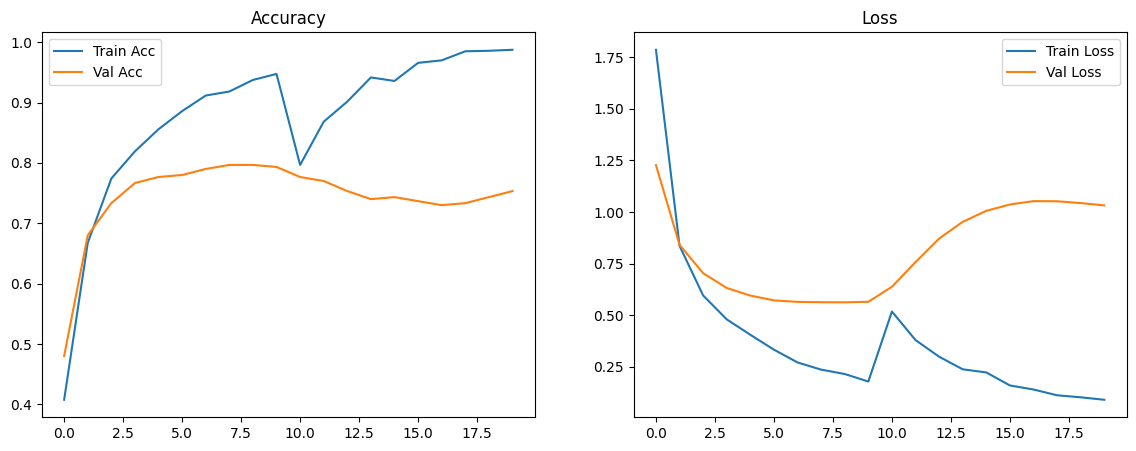

In [11]:
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_class = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_class)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

     drawing       0.92      0.58      0.71        57
      hentai       0.63      0.98      0.77        50
     neutral       0.92      0.52      0.66        64
        porn       0.64      0.95      0.76        58
        sexy       0.88      0.79      0.83        71

    accuracy                           0.75       300
   macro avg       0.80      0.76      0.75       300
weighted avg       0.81      0.75      0.75       300



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


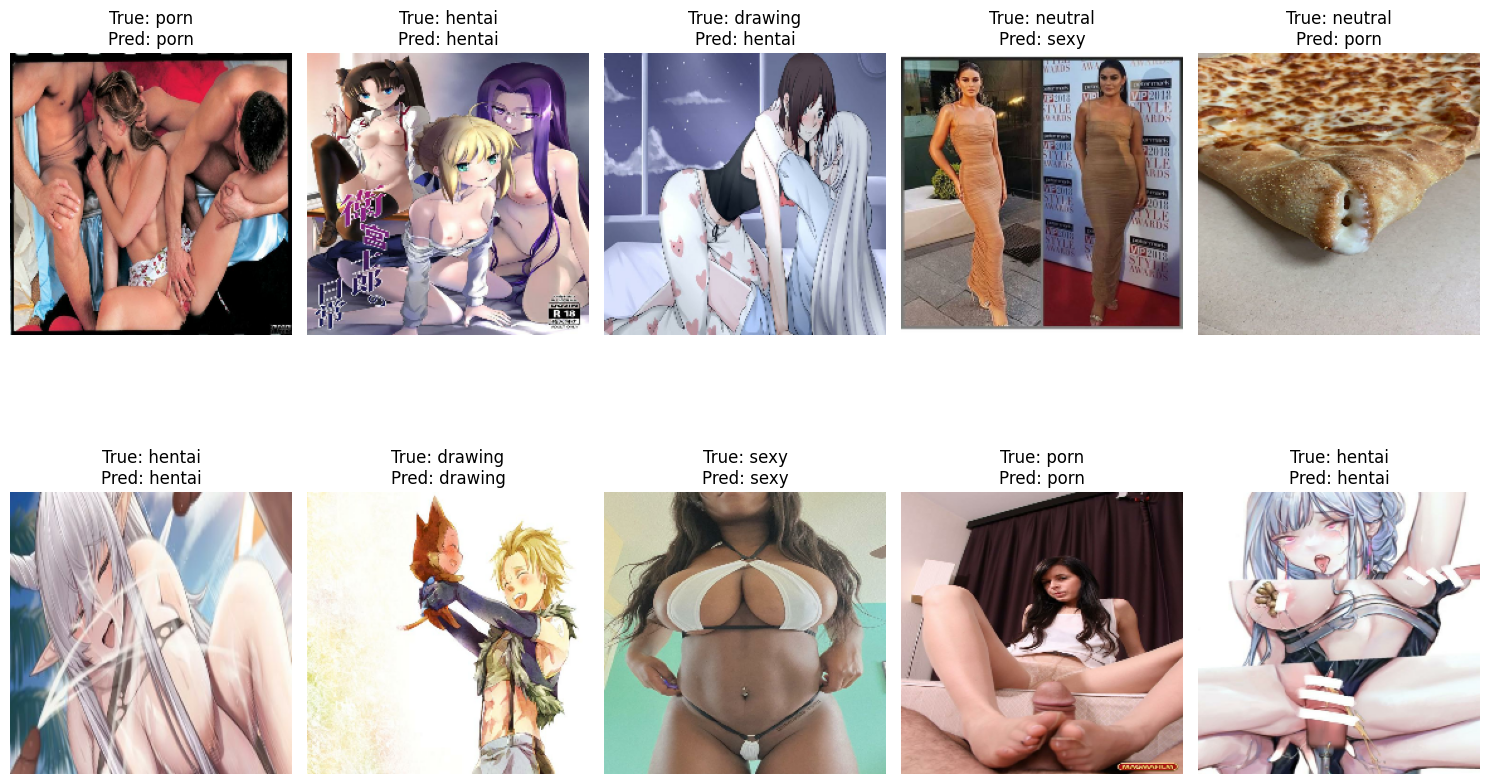

In [13]:
import random

# Take a batch from val_ds
for images, labels in val_ds.take(1):
    break

# Select 10 random indices from the batch
num_samples = 10
# Ensure we don't try to sample more than available images in the batch
num_available_images = len(images)
if num_samples > num_available_images:
    num_samples = num_available_images
random_indices = random.sample(range(num_available_images), num_samples)

# Get the selected images and true labels
selected_images = images.numpy()[random_indices]
selected_true_labels = labels.numpy()[random_indices]

# Make predictions
predictions = model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    # The images are preprocessed to [-1, 1], convert back to [0, 255] for display
    display_image = (selected_images[i] + 1) * 127.5
    display_image = display_image.astype(np.uint8)

    plt.imshow(display_image)
    true_label_name = class_names[selected_true_labels[i]]
    predicted_label_name = class_names[predicted_classes[i]]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()